In [137]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice Nikkey (**^N225**) e o da ação da Toyota (**7203.T**), entre 22/02/1985 e 30/12/2008.

In [138]:
df_nikkey = yf.download("^N225", start="1985-02-21", end="2008-12-30")
df_toyota = yf.download("7203.T", start="1985-02-21", end="2008-12-30")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


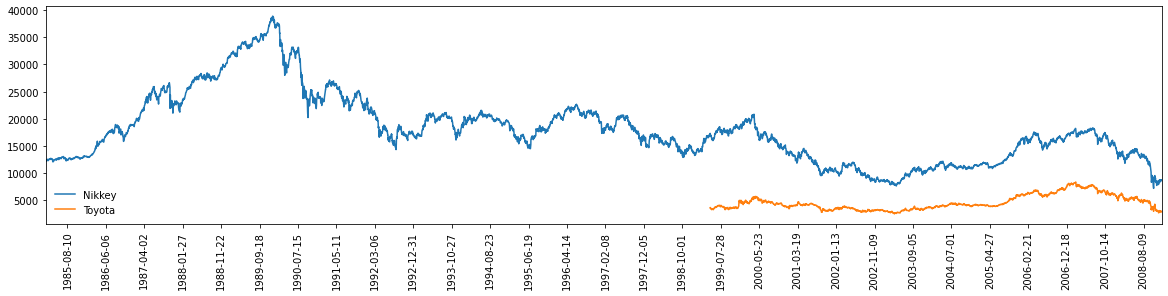

In [139]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_nikkey['Close'], label="Nikkey")
ax.plot(df_toyota['Close'], label="Toyota")

date_min = df_nikkey.index.min()
date_max = df_nikkey.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [141]:
X_train = df_nikkey[:"2008-11-30"]
X_test = df_nikkey["2008-12-01":]

print(f"""Base original: {df_nikkey.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (5880, 6)
X_train: (5860, 6)
X_test: (20, 6)



,Close,rt
Date,,
1985-02-22,12147.059570,0.153238
1985-02-25,12201.040039,0.443407
1985-02-26,12194.969727,-0.049765
1985-02-27,12287.379883,0.754916
1985-02-28,12321.919922,0.280707


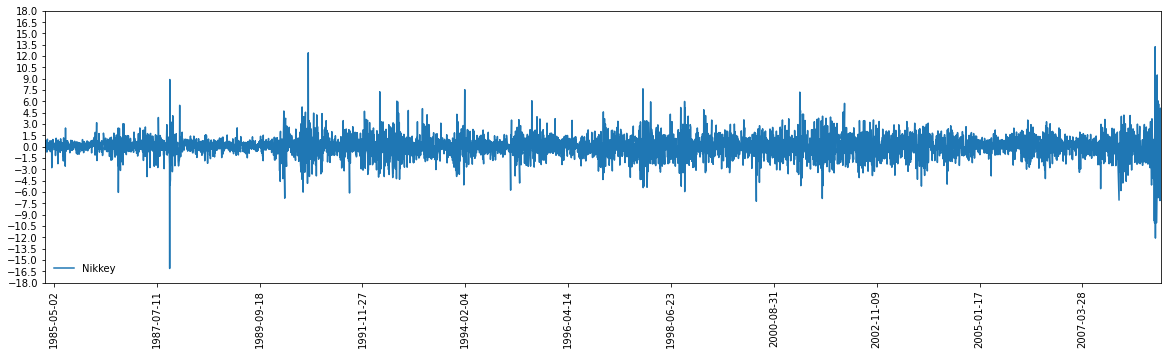

In [143]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [149]:
def uniform_clustering(df: pd.DataFrame) -> pd.DataFrame:
    conditions  = [
        df["rt"] < -1.12,
        (df["rt"] >= -1.12) & (df["rt"] < -0.42),
        (df["rt"] >= -0.42) & (df["rt"] < 0),
        (df["rt"] >= 0) & (df["rt"] < 0.44),
        (df["rt"] >= 0.44) & (df["rt"] < 1.07),
        df["rt"] >= 1.07]
    choices = [ "C1", "C2", "C3", "C4", "C5", "C6"]
    df["Cluster"] = np.select(conditions, choices, default=np.nan)

    return df

In [150]:
X_train = uniform_clustering(X_train)

X_train.head()

,Close,rt,Cluster
Date,,,
1985-02-22,12147.059570,0.153238,C4
1985-02-25,12201.040039,0.443407,C5
1985-02-26,12194.969727,-0.049765,C3
1985-02-27,12287.379883,0.754916,C5
1985-02-28,12321.919922,0.280707,C4


Comparando agrupamento abtido com o agrupamento exposto no artigo.

|Cluster|Artigo|Obtido|
|:-:|-:|-:|
|C1|-2.18|-2.19|
|C2|-0.73|-0.73|
|C3|-0.20|-0.20|
|C4|0.22|0.21|
|C5|0.72|0.72|
|C6|2.04|2.04|

In [82]:
round(df_nikkey.groupby(by=["Cluster"]).agg({"rt": "mean"}), 2)

,rt
Cluster,
C1,-2.19
C2,-0.73
C3,-0.20
C4,0.21
C5,0.72
C6,2.04
